In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from folium.plugins import FastMarkerCluster
from sklearn.metrics import r2_score
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve

## Loading in the Data and some initial EDA
We are looking at the vaccine data from 2009 about H1N1 and Seasonal Flu Vaccine awareness. The purpose of our project is to create a campaign for the CDC that will identify the most important features in increasing turnover rate from those who have little to no knowledge about vaccines so that they are fully armed to protect themselves from these diseases.

In [2]:
# Loading in the datasets that were given to us
vaccinetrainingdf = pd.read_csv("data/training_set_features.csv")
vaccinetestdf = pd.read_csv("data/test_set_features.csv")
vaccinelabelsdf = pd.read_csv("data/training_set_labels.csv")

In [3]:
# Initial checking to see what data types we are working with as well as to see if we had any missing data
vaccinetrainingdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [4]:
vaccinetrainingdf.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [5]:
# We see here that the data is already split almost exactly in half for our training and test data sets
vaccinetestdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26708 non-null  int64  
 1   h1n1_concern                 26623 non-null  float64
 2   h1n1_knowledge               26586 non-null  float64
 3   behavioral_antiviral_meds    26629 non-null  float64
 4   behavioral_avoidance         26495 non-null  float64
 5   behavioral_face_mask         26689 non-null  float64
 6   behavioral_wash_hands        26668 non-null  float64
 7   behavioral_large_gatherings  26636 non-null  float64
 8   behavioral_outside_home      26626 non-null  float64
 9   behavioral_touch_face        26580 non-null  float64
 10  doctor_recc_h1n1             24548 non-null  float64
 11  doctor_recc_seasonal         24548 non-null  float64
 12  chronic_med_condition        25776 non-null  float64
 13  child_under_6_mo

In [6]:
pd.set_option('max_columns', None)
vaccinetestdf.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,35 - 44 Years,College Graduate,Hispanic,Female,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,4.0,1.0,1.0,18 - 34 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,4.0,2.0,5.0,4.0,4.0,55 - 64 Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,4.0,2.0,2.0,4.0,4.0,2.0,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,2.0,4.0,4.0,4.0,2.0,35 - 44 Years,12 Years,Black,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


In [7]:
vaccinelabelsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


In [8]:
vaccinelabelsdf['h1n1_vaccine'].value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

In [9]:
# Dropping data we deemed unnecessary/irrelevant to our business problem
columns_to_drop = ['respondent_id','h1n1_knowledge', 'employment_occupation', 'employment_industry', 'household_children', 'household_adults', 'census_msa', 'hhs_geo_region',
                    'employment_status', 'rent_or_own', 'marital_status', 'opinion_seas_sick_from_vacc', 'opinion_seas_risk', 'health_insurance', 'child_under_6_months',
                    'health_worker']
X_train = vaccinetrainingdf.copy().drop(columns_to_drop, axis = 1)
X_test = vaccinetestdf.copy().drop(columns_to_drop, axis = 1)
y_train = vaccinetrainingdf['h1n1_knowledge']
y_test = vaccinetestdf['h1n1_knowledge']

In [10]:
# Checking our data again to see that we dropped the irrelevant columns. 
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   behavioral_antiviral_meds    26636 non-null  float64
 2   behavioral_avoidance         26499 non-null  float64
 3   behavioral_face_mask         26688 non-null  float64
 4   behavioral_wash_hands        26665 non-null  float64
 5   behavioral_large_gatherings  26620 non-null  float64
 6   behavioral_outside_home      26625 non-null  float64
 7   behavioral_touch_face        26579 non-null  float64
 8   doctor_recc_h1n1             24547 non-null  float64
 9   doctor_recc_seasonal         24547 non-null  float64
 10  chronic_med_condition        25736 non-null  float64
 11  opinion_h1n1_vacc_effective  26316 non-null  float64
 12  opinion_h1n1_risk            26319 non-null  float64
 13  opinion_h1n1_sic

In [11]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26623 non-null  float64
 1   behavioral_antiviral_meds    26629 non-null  float64
 2   behavioral_avoidance         26495 non-null  float64
 3   behavioral_face_mask         26689 non-null  float64
 4   behavioral_wash_hands        26668 non-null  float64
 5   behavioral_large_gatherings  26636 non-null  float64
 6   behavioral_outside_home      26626 non-null  float64
 7   behavioral_touch_face        26580 non-null  float64
 8   doctor_recc_h1n1             24548 non-null  float64
 9   doctor_recc_seasonal         24548 non-null  float64
 10  chronic_med_condition        25776 non-null  float64
 11  opinion_h1n1_vacc_effective  26310 non-null  float64
 12  opinion_h1n1_risk            26328 non-null  float64
 13  opinion_h1n1_sic

## Feature Engineering
Created some frequently used functions that we will be utilizing throughout our project

In [12]:
# Defined a OneHotEncoder function for ease of access
def OHE(X_train, categories):
    onehot = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
    x_train_cat = pd.DataFrame(onehot.fit_transform(X_train[categories]))
    x_train_cat.columns = onehot.get_feature_names(categories)
    # Reset indices to avoid merging conflicts
    x_train_cat.reset_index(drop=True, inplace=True)
    X_train.reset_index(drop=True, inplace=True)
    # Joined the OHE dataframe to the dataframe that is passed into the function
    x_train_df = X_train.drop(categories, axis = 1).join(x_train_cat)
    return x_train_df

def confusion_and_metrics(model, X_test, y_test, y_pred):
    # Accuracy Score
    print(f"Accuracy Score: {model.score(X_test, y_test):.3f}")
    # Recall Score
    print(f"Recall Score: {recall_score(y_test, y_pred):.3f}")
    # Plot confusion matrix for visualization
    plot_confusion_matrix(model, X_test, y_test);
    

In [13]:
X_train

,h1n1_concern,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,age_group,education,race,sex,income_poverty
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty
1,3.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,4.0,4.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,3.0,1.0,1.0,4.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty"
3,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,5.0,5.0,65+ Years,12 Years,White,Female,Below Poverty
4,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,3.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,5.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty"
26703,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,2.0,2.0,5.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty"
26704,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,2.0,5.0,55 - 64 Years,Some College,White,Female,NaN
26705,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,3.0,1.0,2.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty"


In [14]:
# Created a SimpleImputer to replace the NaN values with the most_frequent(mode) values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'most_frequent')
imputed_X_train = imputer.fit_transform(X_train)
imputed_X_train_df = pd.DataFrame(imputed_X_train)

In [15]:
imputed_X_test = imputer.transform(X_test)
imputed_X_test_df = pd.DataFrame(imputed_X_test)
imputed_X_test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2,0,1,0,1,1,0,1,0,0,0,5,1,1,5,35 - 44 Years,College Graduate,Hispanic,Female,"> $75,000"
1,1,0,0,0,0,0,0,0,0,0,0,4,1,1,4,18 - 34 Years,12 Years,White,Male,Below Poverty
2,2,0,0,1,1,1,1,1,0,0,0,5,4,2,5,55 - 64 Years,College Graduate,White,Male,"> $75,000"
3,1,0,0,0,0,0,0,0,1,1,1,4,2,2,4,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty"
4,3,1,1,0,1,1,1,1,0,0,0,5,2,4,4,35 - 44 Years,12 Years,Black,Female,"<= $75,000, Above Poverty"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26703,1,0,1,0,1,0,0,1,1,1,0,4,2,2,4,35 - 44 Years,College Graduate,White,Female,"<= $75,000, Above Poverty"
26704,3,0,1,0,1,1,1,1,0,0,0,4,1,1,5,18 - 34 Years,12 Years,White,Male,Below Poverty
26705,0,0,0,0,0,0,0,0,0,0,0,4,3,1,4,18 - 34 Years,Some College,White,Female,Below Poverty
26706,3,0,1,0,1,0,1,0,0,0,0,2,3,4,4,55 - 64 Years,Some College,White,Female,"<= $75,000, Above Poverty"


In [16]:
# Created a dictionary of names to rename the columns after imputing
dictionary_of_names = {0:'h1n1_concern', 1:'behavioral_antiviral_meds',
                       2:'behavioral_avoidance', 3:'behavioral_face_mask', 4:'behavioral_wash_hands',
                       5:'behavioral_large_gatherings', 6:'behavioral_outside_home', 7:'behavioral_touch_face',
                       8:'doctor_recc_h1n1', 9:'doctor_recc_seasonal', 10:'chronic_med_condition',
                      11:'opinion_h1n1_vacc_effective', 12:'opinion_h1n1_risk', 13:'opinion_h1n1_sick_from_vacc',
                       14:'opinion_seas_vacc_effective', 15:'age_group', 16:'education', 17:'race', 18:'sex', 19:'income_poverty'}
imputed_X_train_df_plus_column_names = imputed_X_train_df.rename(dictionary_of_names, axis = 1)
imputed_X_test_df_plus_column_names = imputed_X_test_df.rename(dictionary_of_names, axis = 1)

In [17]:
imputed_X_test_df_plus_column_names

,h1n1_concern,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,age_group,education,race,sex,income_poverty
0,2,0,1,0,1,1,0,1,0,0,0,5,1,1,5,35 - 44 Years,College Graduate,Hispanic,Female,"> $75,000"
1,1,0,0,0,0,0,0,0,0,0,0,4,1,1,4,18 - 34 Years,12 Years,White,Male,Below Poverty
2,2,0,0,1,1,1,1,1,0,0,0,5,4,2,5,55 - 64 Years,College Graduate,White,Male,"> $75,000"
3,1,0,0,0,0,0,0,0,1,1,1,4,2,2,4,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty"
4,3,1,1,0,1,1,1,1,0,0,0,5,2,4,4,35 - 44 Years,12 Years,Black,Female,"<= $75,000, Above Poverty"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26703,1,0,1,0,1,0,0,1,1,1,0,4,2,2,4,35 - 44 Years,College Graduate,White,Female,"<= $75,000, Above Poverty"
26704,3,0,1,0,1,1,1,1,0,0,0,4,1,1,5,18 - 34 Years,12 Years,White,Male,Below Poverty
26705,0,0,0,0,0,0,0,0,0,0,0,4,3,1,4,18 - 34 Years,Some College,White,Female,Below Poverty
26706,3,0,1,0,1,0,1,0,0,0,0,2,3,4,4,55 - 64 Years,Some College,White,Female,"<= $75,000, Above Poverty"


In [18]:
imputed_X_train_df_plus_column_names

,h1n1_concern,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,age_group,education,race,sex,income_poverty
0,1,0,0,0,0,0,1,1,0,0,0,3,1,2,2,55 - 64 Years,< 12 Years,White,Female,Below Poverty
1,3,0,1,0,1,0,1,1,0,0,0,5,4,4,4,35 - 44 Years,12 Years,White,Male,Below Poverty
2,1,0,1,0,0,0,0,0,0,0,1,3,1,1,4,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty"
3,1,0,1,0,1,1,0,0,0,1,1,3,3,5,5,65+ Years,12 Years,White,Female,Below Poverty
4,2,0,1,0,1,1,0,1,0,0,0,3,3,2,3,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2,0,1,0,0,0,1,0,0,0,0,3,1,1,5,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty"
26703,1,0,1,0,1,0,0,0,1,1,0,4,2,2,5,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty"
26704,2,0,1,1,1,1,0,1,0,0,0,4,4,2,5,55 - 64 Years,Some College,White,Female,"<= $75,000, Above Poverty"
26705,1,0,0,0,0,0,0,1,0,0,0,3,1,2,2,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty"


In [19]:
#X_train_column_names = X_train.columns.values.tolist()
#type(X_train_column_names)
#list_of_numbers = list(range(0, 21))
#list_of_numbers

In [20]:
#dictionary_of_names = {key: X_train_column_names[0] for key in list_of_numbers}
#dictionary_of_names

In [21]:
#X_train_column_names

In [22]:
# Turned imputeddf into an array to be used in 
imputeddf_array = imputed_X_train_df_plus_column_names.to_numpy()
type(imputeddf_array)

numpy.ndarray

In [23]:
X_train

,h1n1_concern,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,age_group,education,race,sex,income_poverty
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty
1,3.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,4.0,4.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,3.0,1.0,1.0,4.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty"
3,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,5.0,5.0,65+ Years,12 Years,White,Female,Below Poverty
4,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,3.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,5.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty"
26703,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,2.0,2.0,5.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty"
26704,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,2.0,5.0,55 - 64 Years,Some College,White,Female,NaN
26705,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,3.0,1.0,2.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty"


In [24]:
X_train

,h1n1_concern,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,age_group,education,race,sex,income_poverty
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty
1,3.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,4.0,4.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,3.0,1.0,1.0,4.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty"
3,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,5.0,5.0,65+ Years,12 Years,White,Female,Below Poverty
4,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,3.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,5.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty"
26703,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,2.0,2.0,5.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty"
26704,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,2.0,5.0,55 - 64 Years,Some College,White,Female,NaN
26705,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,3.0,1.0,2.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty"


In [25]:
# Called the OHE function we made and assigned new dataframe variables
ohe_training_df = OHE(imputed_X_train_df_plus_column_names, ['age_group', 'education','race', 'sex', 'income_poverty'])
ohe_test_df = OHE(imputed_X_test_df_plus_column_names, ['age_group', 'education','race', 'sex', 'income_poverty'])
ohe_training_df

,h1n1_concern,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty
0,1,0,0,0,0,0,1,1,0,0,0,3,1,2,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,3,0,1,0,1,0,1,1,0,0,0,5,4,4,4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1,0,1,0,0,0,0,0,0,0,1,3,1,1,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1,0,1,0,1,1,0,0,0,1,1,3,3,5,5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,2,0,1,0,1,1,0,1,0,0,0,3,3,2,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2,0,1,0,0,0,1,0,0,0,0,3,1,1,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
26703,1,0,1,0,1,0,0,0,1,1,0,4,2,2,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
26704,2,0,1,1,1,1,0,1,0,0,0,4,4,2,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
26705,1,0,0,0,0,0,0,1,0,0,0,3,1,2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [26]:
X_train['age_group'].value_counts()

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64

In [27]:
X_train['education'].value_counts()

College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64

In [28]:
X_train['race'].value_counts()

White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64

In [29]:
X_train['sex'].value_counts()

Female    15858
Male      10849
Name: sex, dtype: int64

In [30]:
X_train['income_poverty'].value_counts()

<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64

In [31]:
# Instead of calling SimpleImputer/removing the NaN variables in the target column, we performed an imputation which replaced all the NaN values with the most frequent value
# which in this case would be 1.0 (little knowledge of vaccine)
y_train.replace(np.nan, 1.0, inplace = True)
y_test.replace(np.nan, 1.0, inplace = True)

In [32]:
y_test.isna().value_counts()

False    26708
Name: h1n1_knowledge, dtype: int64

In [33]:
y_train.isna().value_counts()

False    26707
Name: h1n1_knowledge, dtype: int64

In [34]:
# Binning all the 1.0s with the 0.0s
y_train.replace(1.0, 0.0, inplace = True)
y_test.replace(1.0, 0.0, inplace = True)
# Replacing all the 2.0s with 1.0s (so now we binned little to no knowledge together as a 0.0 and a lot of knowledge as 1.0 since we want a higher turnover rate of those who are knowledgeable about vaccines/influenza)
y_train.replace(2.0, 1.0, inplace = True)
y_test.replace(2.0, 1.0, inplace = True)

In [35]:
# Checking to see if we replaced our values correctly
y_train.value_counts()

0.0    17220
1.0     9487
Name: h1n1_knowledge, dtype: int64

In [36]:
# Checking to see if we replaced our values correctly
y_test.value_counts()

0.0    17193
1.0     9515
Name: h1n1_knowledge, dtype: int64

In [37]:
ohe_training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   h1n1_concern                              26707 non-null  object 
 1   behavioral_antiviral_meds                 26707 non-null  object 
 2   behavioral_avoidance                      26707 non-null  object 
 3   behavioral_face_mask                      26707 non-null  object 
 4   behavioral_wash_hands                     26707 non-null  object 
 5   behavioral_large_gatherings               26707 non-null  object 
 6   behavioral_outside_home                   26707 non-null  object 
 7   behavioral_touch_face                     26707 non-null  object 
 8   doctor_recc_h1n1                          26707 non-null  object 
 9   doctor_recc_seasonal                      26707 non-null  object 
 10  chronic_med_condition             

In [38]:
#Since our data is severly imbalanced, we utilize SMOTE to undersample our data.
# Since we SMOTE our training dataset, we must SMOTE our test dataset as well.

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

over = SMOTE(sampling_strategy=0.7)
under = RandomUnderSampler(sampling_strategy=0.8)

X_smote, y_smote = under.fit_resample(ohe_training_df, y_train)
X_test_smote, y_test_smote = under.fit_resample(ohe_test_df, y_test)

counter = Counter(y_train)
test_counter = Counter(y_test_smote)
print(counter)
print(test_counter)


Counter({0.0: 17220, 1.0: 9487})
Counter({0.0: 11893, 1.0: 9515})


In [39]:
# Created Dummy Classifier model to look at simple accuracy score
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier()
dummy.fit(X_smote, y_smote)
y_pred = dummy.predict(X_smote)
y_test_pred = dummy.predict(X_test_smote)
y_pred_df = pd.DataFrame(y_pred)
dummy.score(X_test_smote, y_test_smote)

C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


0.5071935724962631

In [40]:
# Displayed cross validation score for the dummy model
from sklearn.model_selection import train_test_split, cross_val_score

dummy_cross_val = cross_val_score(dummy, X_smote, y_pred_df)

dummy_cross_val

C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


array([0.50386507, 0.50433357, 0.51440618, 0.50456781, 0.50175685])

In [41]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier (random_state = 10)
dt.fit(X_smote, y_smote)
y_dt_pred = dt.predict(X_smote)
y_dt_test_pred = dt.predict(X_test_smote)
dt.score(X_test_smote, y_test_smote)

0.5565676382660688

In [42]:
# Created grid paramater to perform a GridSearch to find optimal decision tree parameters
grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [100, 500, 1000, 5000],
    'min_samples_leaf': [100, 500, 1000, 5000]
}

gs = GridSearchCV(estimator = dt, param_grid = grid, cv = 5)
gs.fit(ohe_training_df, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=10),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [100, 500, 1000, 5000],
                         'min_samples_split': [100, 500, 1000, 5000]})

In [43]:
gs.best_params_

{'max_depth': 7, 'min_samples_leaf': 100, 'min_samples_split': 100}

In [44]:
gs.best_score_

0.6770884108866996

In [45]:
gs.best_estimator_.score(ohe_test_df, y_test)


0.6696495432080276

In [46]:
gs.n_features_in_

33

In [47]:
# Converted the results from the GridSearch to a DataFrame for easier visualization
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.052079,0.002198,0.012168,0.001595,1,100,100,"{'max_depth': 1, 'min_samples_leaf': 100, 'min...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109
1,0.049486,0.001962,0.011769,0.000746,1,100,500,"{'max_depth': 1, 'min_samples_leaf': 100, 'min...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109
2,0.055005,0.004263,0.012257,0.000745,1,100,1000,"{'max_depth': 1, 'min_samples_leaf': 100, 'min...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109
3,0.053668,0.002918,0.011769,0.000747,1,100,5000,"{'max_depth': 1, 'min_samples_leaf': 100, 'min...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109
4,0.051040,0.002895,0.011494,0.001301,1,500,100,"{'max_depth': 1, 'min_samples_leaf': 500, 'min...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.066453,0.004472,0.011370,0.001353,10,1000,5000,"{'max_depth': 10, 'min_samples_leaf': 1000, 'm...",0.659865,0.666604,0.668976,0.657742,0.665980,0.663833,0.004280,73
156,0.052199,0.001718,0.011370,0.001955,10,5000,100,"{'max_depth': 10, 'min_samples_leaf': 5000, 'm...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109
157,0.051733,0.001873,0.010173,0.001466,10,5000,500,"{'max_depth': 10, 'min_samples_leaf': 5000, 'm...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109
158,0.055253,0.003432,0.012367,0.001621,10,5000,1000,"{'max_depth': 10, 'min_samples_leaf': 5000, 'm...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109


In [48]:
dt2 = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 100, min_samples_split = 100, random_state = 10)
dt2.fit(X_smote, y_smote)
y_dt2_pred = dt.predict(X_smote)
y_dt2_test_pred = dt.predict(X_test_smote)
dt2.score(X_test_smote, y_test_smote)

0.6225710014947683

Accuracy Score: 0.508
Recall Score: 0.444


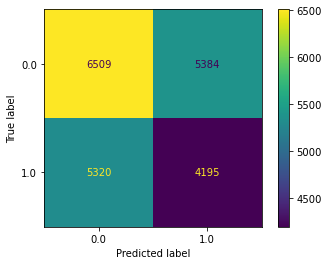

In [49]:
# Called function and printed out confusion and printed out Accuracy/Recall Score for DummyClassifier
confusion_and_metrics(dummy, X_test_smote, y_test_smote, y_test_pred)

Accuracy Score: 0.557
Recall Score: 0.506


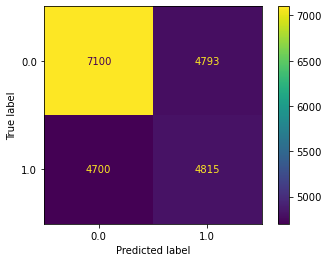

In [50]:
# Called function and printed out confusion matrix and metrics of iniital decision tree
confusion_and_metrics(dt, X_test_smote, y_test_smote, y_dt_test_pred)

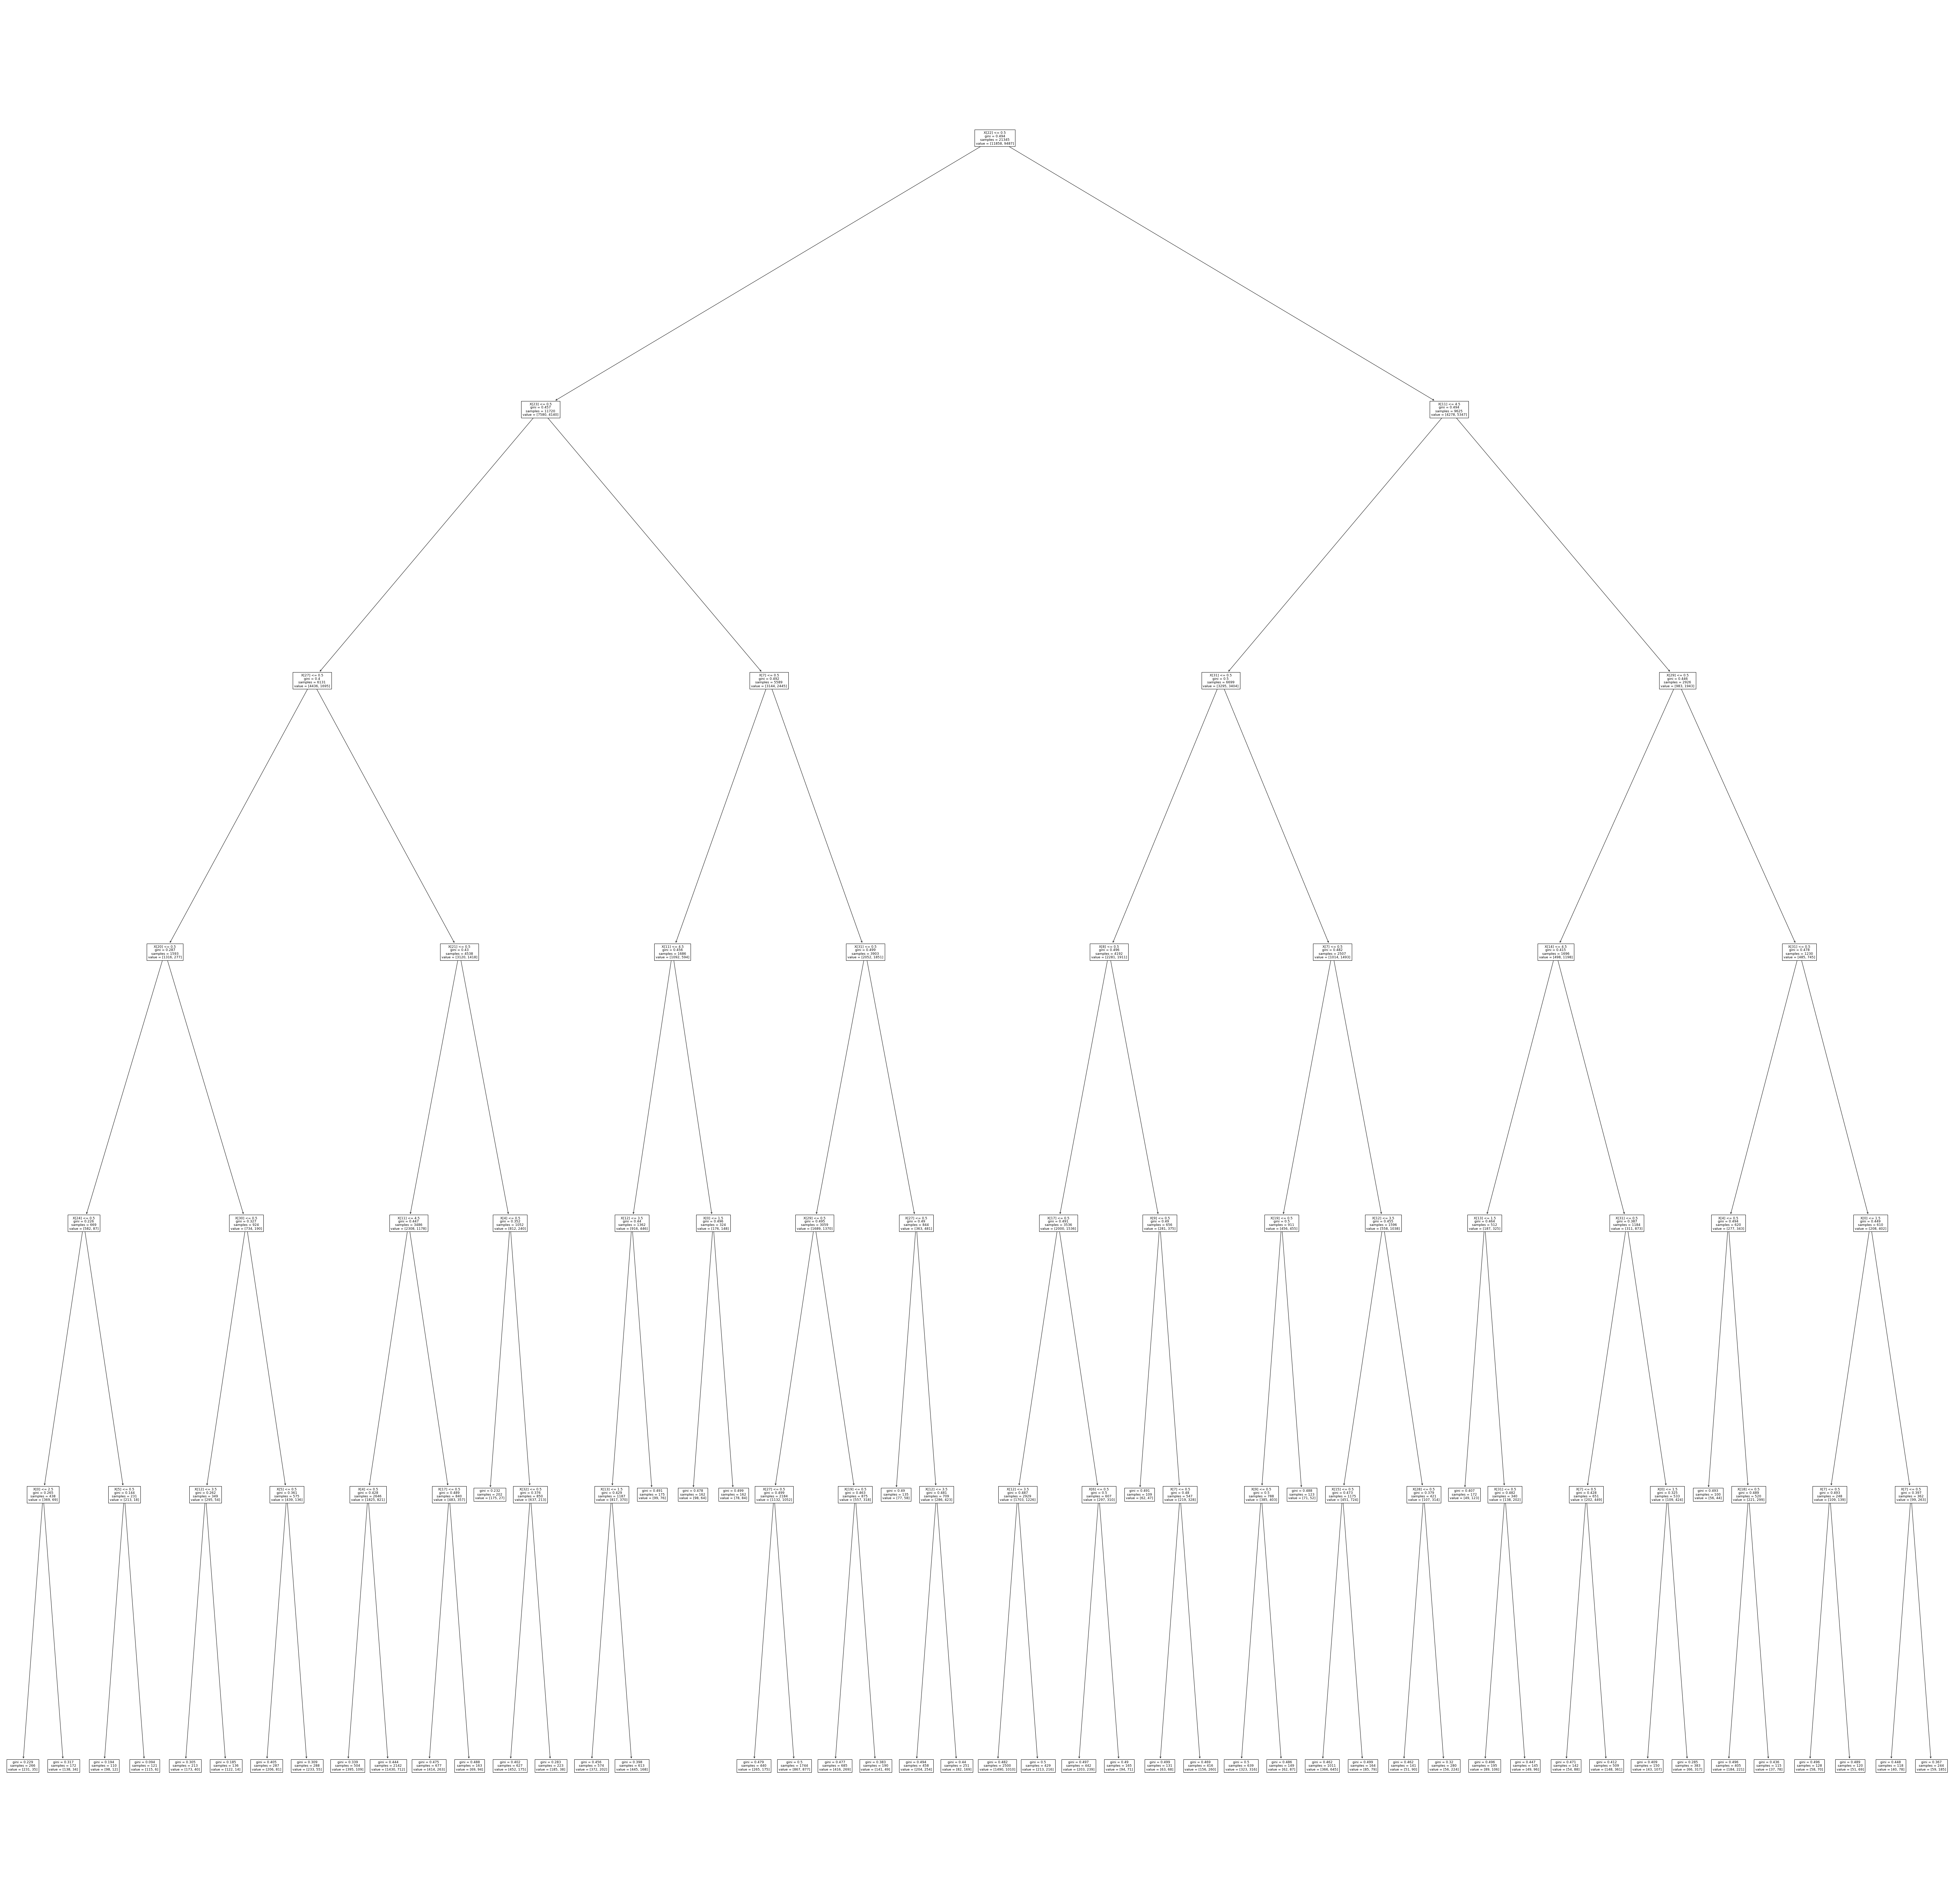

In [51]:
f, ax = plt.subplots(figsize=(100, 100))
plot_tree(dt2, ax=ax);
# plt.savefig('out.pdf')

Accuracy Score: 0.623
Recall Score: 0.506


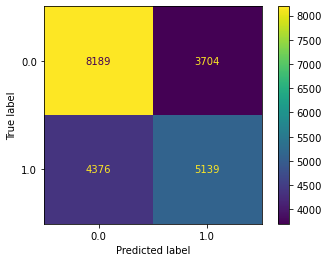

In [52]:
confusion_and_metrics(dt2, X_test_smote, y_test_smote, y_dt2_test_pred)

In [53]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_smote, y_smote)
y_lr_pred = model.predict(X_smote)
y_lr_test_pred = model.predict(X_test_smote)
model.score(X_test_smote, y_test_smote)

C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6377989536621823

Accuracy Score: 0.638
Recall Score: 0.539


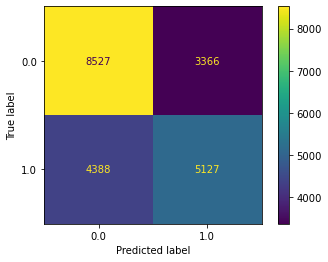

In [54]:
confusion_and_metrics(model, X_test_smote, y_test_smote, y_lr_test_pred)

In [55]:
grid2 = {
    'penalty': ['l1','l2','elasticnet'],
    'class_weight': ['balanced', 'None'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

gs2 = GridSearchCV(estimator = model, param_grid = grid2, cv = 5)
gs2.fit(X_smote, y_smote)

C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Us

C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\

C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'class_weight': ['balanced', 'None'],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [56]:
gs2.best_params_

{'class_weight': 'None', 'penalty': 'l1', 'solver': 'saga'}

In [57]:
model2 = LogisticRegression(random_state=42, penalty = 'l1', solver = 'liblinear')
model2.fit(X_smote, y_smote)
y_lr2_pred = model2.predict(X_smote)
y_lr2_test_pred = model2.predict(X_test_smote)
model2.score(X_test_smote, y_test_smote)

0.6378923766816144

Accuracy Score: 0.638
Recall Score: 0.539


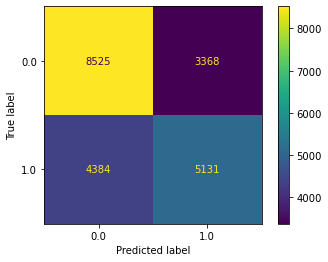

In [58]:
confusion_and_metrics(model2, X_test_smote, y_test_smote, y_lr2_test_pred)

[0.09622029 0.01439556 0.03647152 0.0174804  0.02149106 0.03791999
 0.03661101 0.02759544 0.02059469 0.02916386 0.04191872 0.09862972
 0.09396121 0.10110855 0.08897996 0.01557008 0.01613691 0.01704263
 0.01752662 0.01498885 0.01169819 0.01202741 0.02455989 0.00975281
 0.0076846  0.00719513 0.00830174 0.01423863 0.01242048 0.01278009
 0.01070752 0.01629165 0.00853481]


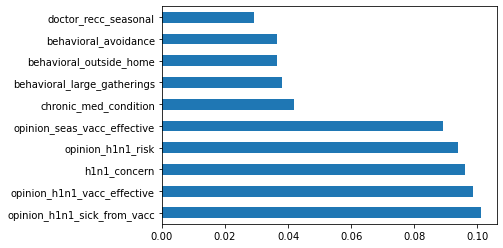

In [60]:
X = ohe_training_df.iloc[:,0:33]  #independent columns
y = y_train    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [62]:
ohe_training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   h1n1_concern                              26707 non-null  object 
 1   behavioral_antiviral_meds                 26707 non-null  object 
 2   behavioral_avoidance                      26707 non-null  object 
 3   behavioral_face_mask                      26707 non-null  object 
 4   behavioral_wash_hands                     26707 non-null  object 
 5   behavioral_large_gatherings               26707 non-null  object 
 6   behavioral_outside_home                   26707 non-null  object 
 7   behavioral_touch_face                     26707 non-null  object 
 8   doctor_recc_h1n1                          26707 non-null  object 
 9   doctor_recc_seasonal                      26707 non-null  object 
 10  chronic_med_condition             